Local copy of the dataset file: /Users/ian/.keras/datasets/iris_training.csv
Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species
OrderedDict([('sepal_length', <tf.Tensor: id=97727, shape=(32,), dtype=float32, numpy=
array([6.1, 5. , 4.9, 6. , 5.7, 5.7, 6.2, 5.8, 6.8, 5.8, 6.6, 4.8, 5.8,
       6.1, 6.7, 5.1, 4.6, 4.4, 7.3, 5.9, 6.4, 6.4, 4.6, 5.6, 6.3, 6.5,
       5. , 5. , 7.6, 5.8, 5.7, 6.9], dtype=float32)>), ('sepal_width', <tf.Tensor: id=97728, shape=(32,), dtype=float32, numpy=
array([2.6, 3.4, 2.4, 2.7, 3.8, 2.8, 3.4, 2.7, 3.2, 4. , 2.9, 3.4, 2.7,
       3. , 3.3, 3.8, 3.4, 3. , 2.9, 3. , 3.2, 2.7, 3.6, 2.5, 3.4, 3. ,
       2. , 3.5, 3. , 2.6, 4.4, 3.2], dtype=float32)>), ('petal_length', <tf.Tensor: id=97725, shape=(32,), dtype=float32, numpy=
array([5.6, 1.5, 3.3, 5.1, 1.7, 4.5, 5.4, 5.1, 5.9, 1.2, 4.6, 1.6, 5.1,
       4.9, 5.7, 1.6, 1.4, 1.3, 6.3, 5.1, 4.5, 5.3, 1. , 3.9, 5.6, 5.2,
       3.5, 1.3, 6.6, 4. , 1.5, 5.7], dtype=float32)>), (

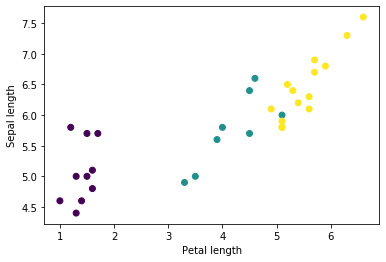

In [15]:

import os
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))
# column order in CSV file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']
batch_size = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)
features, labels = next(iter(train_dataset))

print(features)
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()


In [3]:
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels
train_dataset = train_dataset.map(pack_features_vector)
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[5.7 4.4 1.5 0.4]
 [7.7 2.6 6.9 2.3]
 [5.4 3.7 1.5 0.2]
 [6.2 2.2 4.5 1.5]
 [7.2 3.  5.8 1.6]], shape=(5, 4), dtype=float32)


In [4]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])
predictions = model(features)
predictions[:5]

<tf.Tensor: id=231, shape=(5, 3), dtype=float32, numpy=
array([[ 2.5993013 ,  2.3718677 , -0.07333842],
       [ 2.3492987 ,  3.0926049 , -0.7735538 ],
       [ 2.357014  ,  2.1833246 , -0.03486017],
       [ 2.0669265 ,  2.497304  , -0.4603233 ],
       [ 2.372506  ,  2.8738635 , -0.6062058 ]], dtype=float32)>

In [5]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
def loss(model, x, y):
  y_ = model(x)

  return loss_object(y_true=y, y_pred=y_)


l = loss(model, features, labels)
print("Loss test: {}".format(l))

Loss test: 1.705547571182251


In [6]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [7]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)


In [8]:
# loss_value, grads = grad(model, features, labels)

# print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
#                                           loss_value.numpy()))

# optimizer.apply_gradients(zip(grads, model.trainable_variables))

# print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
#                                           loss(model, features, labels).numpy()))

Step: 0, Initial Loss: 1.705547571182251
Step: 1,         Loss: 1.482947587966919


In [9]:
## Note: Rerunning this cell uses the same model variables

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    epoch_accuracy(y, model(x))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.288, Accuracy: 65.000%
Epoch 050: Loss: 0.381, Accuracy: 94.167%
Epoch 100: Loss: 0.239, Accuracy: 96.667%
Epoch 150: Loss: 0.163, Accuracy: 97.500%
Epoch 200: Loss: 0.128, Accuracy: 97.500%


In [ ]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

In [11]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 1us/step


In [12]:
test_dataset = tf.data.experimental.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

In [13]:
test_accuracy = tf.keras.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%


In [16]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Iris setosa (97.4%)
Example 1 prediction: Iris versicolor (91.7%)
Example 2 prediction: Iris virginica (75.0%)
